In [9]:
# Interactive Figure
%matplotlib ipympl 
# Non interactive
# %matplotlib inline 

In [10]:
import time
import numpy as np
from matplotlib import pyplot as plt
from qualang_tools.units import unit
u = unit(coerce_to_integer=True)
from qm.qua import *
from qm import QuantumMachinesManager
from qm import SimulationConfig
from qualang_tools.results import fetching_tool
from qualang_tools.loops import from_array
import config_00 as config
import warnings
warnings.filterwarnings("ignore")

In [11]:
def addjob(qmprog, qm):
    # Add a QUA program to the OPX queue, which compiles it and executes it
    job = qm.queue.add(qmprog)
    # Wait for job to be loaded
    while job.status=="loading":
        print("Job is loading...")
        time.sleep(0.1)
    # Wait until job is running
    time.sleep(0.1)
    while job.status=="pending":
        q = job.position_in_queue()
        if q>0:
            print("Position in queue",q,end='\r')
        time.sleep(0.1)
    job=job.wait_for_execution()
    print("\nJob is running")
    return job

In [12]:
# Connect to the cluster (run only once)
import QM_cluster
qmm = QuantumMachinesManager(host=QM_cluster.QM_Router_IP, cluster_name=QM_cluster.cluster_name)

2025-05-21 11:54:02,417 - qm - INFO     - Performing health check
2025-05-21 11:54:02,424 - qm - INFO     - Health check passed


# Connexion à la Quantum Machine

In [18]:
# Get the QM reference (rerun every time the config is changed)
qm_list =  qmm.list_open_qms()
qm = qmm.get_qm(qm_list[0])
print(f"Connected to {qm.id}")

Connected to qm-1690915556761


# Envoyer des pulses et les observer

In [19]:
# This block is using QUA directives which are compiled to the FPGA
with program() as prog:
    # Variable declaration
    adc_stream = declare_stream(adc_trace=True)
    # Start measurement
    measure('readout', 'scope', adc_stream=adc_stream)
    # Pulse sequence
    play('pulse','qubit')
    wait(24*u.ns)
    play('pulse','qubit')

    # Select data to be sent to the client 
    with stream_processing():
        adc_stream.input1().save('adc_1')
        adc_stream.input2().save('adc_2')

In [20]:
# Run the code and fetch results
job = addjob(prog, qm)
res = fetching_tool(job, ['adc_1','adc_2'])
adc_1, adc_2 = res.fetch_all()
print('Job done')

2025-05-21 15:31:12,898 - qm - INFO     - Sending program to QOP for compilation

Job is running
Job done


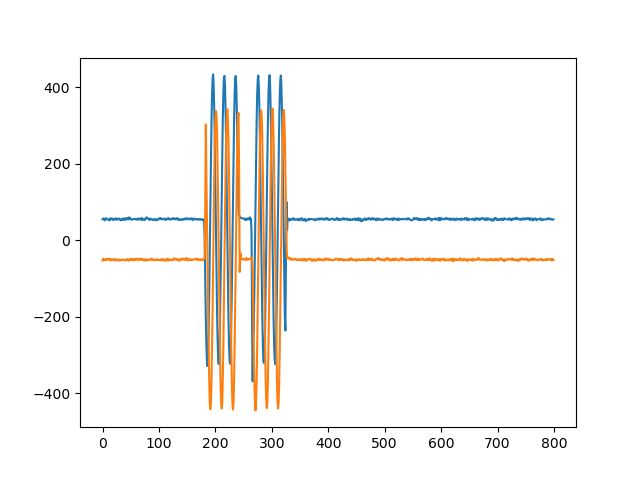

In [21]:
# Plot
t = np.arange(config.readout_len)
fig,ax=plt.subplots()
ax.plot(t,adc_1,t,adc_2)

# Simuler le code QUA

2025-05-21 12:26:26,839 - qm - INFO     - Simulating program


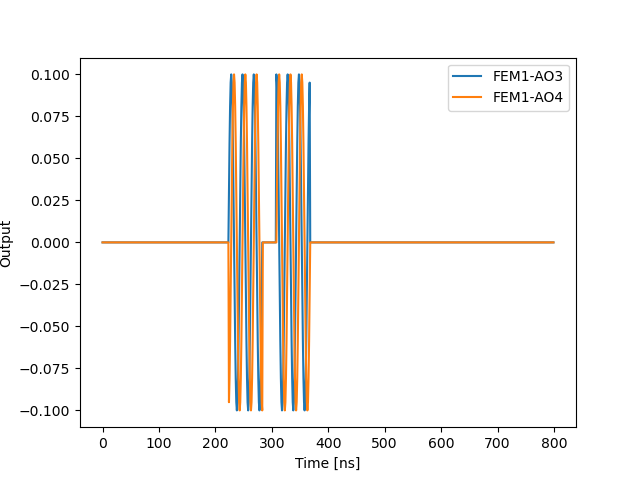

In [17]:
plt.figure()
# Simulates the QUA program for the specified duration
simulation_config = SimulationConfig(duration=config.readout_len//4)  # In clock cycles = 4ns
# Simulate blocks python until the simulation is done
job = qmm.simulate(config.config, prog, simulation_config)
# Get the simulated samples
samples = job.get_simulated_samples()
# Plot the simulated samples
samples.con1.plot()
# Get the waveform report object
waveform_report = job.get_simulated_waveform_report()
# Cast the waveform report to a python dictionary
waveform_dict = waveform_report.to_dict()
# Visualize and save the waveform report
waveform_report.create_plot(samples, plot=True)

# Exercices
- Lien vers la documentation de Quantum Machines [https://docs.quantum-machines.co/latest/](https://docs.quantum-machines.co/latest/)
- Lire la documentation sur la commande [`play`](https://docs.quantum-machines.co/latest/docs/API_references/qua/dsl_main/#for_docs.dsl.play)

## Exercice 1 : Évolution de la phase
- Jouer deux impulsions l’une après l’autre sans temps d’attente. Les tracés sont-ils continus ? Pourquoi ?
- Déphaser la seconde impulsion de $\pi/2$ à l’aide d’une commande [frame_rotation](https://docs.quantum-machines.co/latest/docs/API_references/qua/dsl_main/#for_docs.dsl.frame_rotation). Ajouter à nouveau un délai entre les impulsions et observer l’évolution de la phase.
- Remettre le délai à 0 et, au lieu d’utiliser la frame_rotation, déphaser la seconde impulsion de $\pi/2$ en utilisant la directive [amp](https://docs.quantum-machines.co/latest/docs/API_references/qua/dsl_main/#for_docs.dsl.amp) avec quatre paramètres.

## Exercice 2 : Temporisation des impulsions
- Changer la durée de l’impulsion à 100 ns en utilisant le mot-clé `duration` dans la commande [`play`](https://docs.quantum-machines.co/latest/docs/API_references/qua/dsl_main/#for_docs.dsl.play)
- Lire la documentation sur le [timing](https://docs.quantum-machines.co/latest/docs/Guides/timing_in_qua/)
- Modifier la séquence pour créer deux impulsions séparées par 500 ns

## Exercice 3 : Boucles for
- Écrire une boucle en utilisant [`with for_`](https://docs.quantum-machines.co/latest/docs/Guides/features/#loops) afin de créer un train de 5 impulsions.

## Exercice 4 : Impulsions arbitraires
- Dans la commande play, remplacer `pulse` par `gaussian` et observer les résultats (supprimer tout mot-clé `duration` s’il est présent). Regarder le fichier `config_00.py` pour voir comment les impulsions arbitraires sont construites.
